<a href="https://colab.research.google.com/github/Elwing-Chou/ml0716/blob/master/transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
f = zipfile.ZipFile("drive/My Drive/additional/train.zip")
f.extractall("datas")

In [ ]:
import glob
import pandas as pd
dogs = glob.glob("datas/train/dog.*")
cats = glob.glob("datas/train/cat.*")
df = pd.DataFrame({
    "path":dogs + cats,
    "ans":[0] * len(dogs) + [1] * len(cats)
})
df

,path,ans
0,datas/train/dog.5656.jpg,0
1,datas/train/dog.8713.jpg,0
2,datas/train/dog.6643.jpg,0
3,datas/train/dog.5301.jpg,0
4,datas/train/dog.2056.jpg,0
...,...,...
24995,datas/train/cat.5152.jpg,1
24996,datas/train/cat.3089.jpg,1
24997,datas/train/cat.9365.jpg,1
24998,datas/train/cat.4735.jpg,1


In [17]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential
cnn = VGG16(include_top=False, input_shape=(224, 224, 3))
for layer in cnn.layers:
    layer.trainable = False
mlp = [
    # 512 * 4 = 2048(一半不訓練[原本平均. 標準差], 一半訓練[後來平均, 後來標準差])
    BatchNormalization(),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.25),
    Dense(2, activation="softmax")
]
model = Sequential(cnn.layers + mlp)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [18]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy
model.compile(loss=SparseCategoricalCrossentropy(),
       optimizer="adam",
       metrics=["accuracy"])

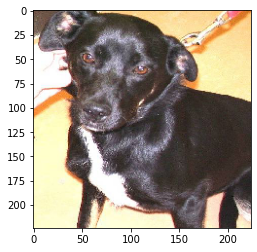

In [19]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img
img = load_img(df["path"][0], target_size=(224, 224))
plt.imshow(img)

In [20]:
import numpy as np
from sklearn.model_selection import train_test_split
# 只要開始處理, 就不要df, 改用np.array
x = np.array(df["path"])
y = np.array(df["ans"])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)

In [21]:
from tensorflow.keras.applications.vgg16 import preprocess_input
# https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
def get_data(x, y, batch=20):
    idx = np.random.randint(0, len(x), batch)
    x_idx, y_idx = x[idx], y[idx]
    x_ori, x_norm, y_ori = [], [], y_idx
    for p in x_idx:
        img = np.array(load_img(p, target_size=(224, 224)))
        img_pre = preprocess_input(img)
        x_ori.append(img)
        x_norm.append(img_pre)
    return np.array(x_ori), np.array(x_norm), np.array(y_ori)
# get_data(x_train, y_train, 1)

In [28]:
for i in range(10):
    print("[times]:", i)
    _, x_batch, y_batch = get_data(x_train, y_train)
    result = model.train_on_batch(x_batch, y_batch)
    print("[Train]:", result)
    _, x_batch, y_batch = get_data(x_test, y_test, 100)
    result = model.test_on_batch(x_batch, y_batch)
    print("[Test]:", result)

[times]: 0
[Train]: [0.48502522706985474, 0.8500000238418579]
[Test]: [1.7744858264923096, 0.949999988079071]
[times]: 1
[Train]: [0.0003355830267537385, 1.0]
[Test]: [2.5453577041625977, 0.9100000262260437]
[times]: 2
[Train]: [5.483608447320876e-07, 1.0]
[Test]: [1.0855352878570557, 0.9599999785423279]
[times]: 3
[Train]: [0.02396947145462036, 1.0]
[Test]: [2.4869205951690674, 0.8999999761581421]
[times]: 4
[Train]: [0.2217664271593094, 0.8999999761581421]
[Test]: [0.8403928875923157, 0.9399999976158142]
[times]: 5
[Train]: [1.1181507110595703, 0.949999988079071]
[Test]: [2.3234026432037354, 0.8700000047683716]
[times]: 6
[Train]: [0.004098610021173954, 1.0]
[Test]: [1.5014843940734863, 0.9300000071525574]
[times]: 7
[Train]: [0.03414301946759224, 1.0]
[Test]: [1.5207198858261108, 0.9200000166893005]
[times]: 8
[Train]: [0.18808013200759888, 0.949999988079071]
[Test]: [1.277619481086731, 0.9200000166893005]
[times]: 9
[Train]: [0.49575376510620117, 0.8999999761581421]
[Test]: [0.9190

In [29]:
model.predict(x_batch)

array([[2.03042597e-20, 1.00000000e+00],
       [1.00000000e+00, 0.00000000e+00],
       [1.08624914e-20, 1.00000000e+00],
       [1.94521302e-10, 1.00000000e+00],
       [1.00000000e+00, 5.64940580e-26],
       [1.00000000e+00, 0.00000000e+00],
       [2.25242684e-22, 1.00000000e+00],
       [1.00000000e+00, 1.41078424e-32],
       [1.05198484e-29, 1.00000000e+00],
       [1.08622226e-31, 1.00000000e+00],
       [1.00000000e+00, 1.25962637e-24],
       [9.15103162e-16, 1.00000000e+00],
       [1.00000000e+00, 4.12611279e-37],
       [1.00000000e+00, 3.46476747e-22],
       [1.00000000e+00, 0.00000000e+00],
       [6.95347854e-25, 1.00000000e+00],
       [1.30734179e-07, 9.99999881e-01],
       [2.26442282e-07, 9.99999762e-01],
       [1.00000000e+00, 0.00000000e+00],
       [3.30055774e-23, 1.00000000e+00],
       [2.38611319e-25, 1.00000000e+00],
       [8.46476616e-14, 1.00000000e+00],
       [1.00000000e+00, 9.99458983e-15],
       [1.00000000e+00, 9.91454592e-29],
       [1.000000

In [32]:
x_ori, x_batch, y_batch = get_data(x_test, y_test, 1000)
model.evaluate(x_batch, y_batch)

32/32 [==============================] - 7s 217ms/step - loss: 1.1453 - accuracy: 0.9460


[1.145305871963501, 0.9459999799728394]

In [ ]:
# argmax: 找最大值的index, 通常都是最後一個軸(-1)
pre = model.predict(x_batch).argmax(axis=-1)
pre

In [38]:
trans = ["dog", "cat"]

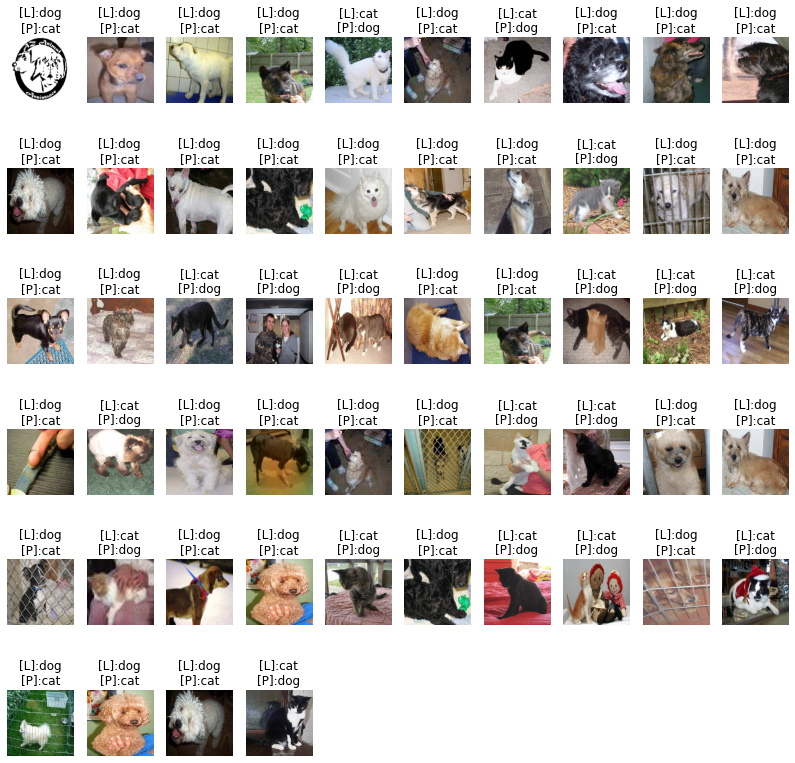

In [40]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(14, 14))
idx = np.nonzero(pre != y_batch)[0]
idx = idx[:200]
width = 10
height = len(idx) // width + 1
for i, d  in enumerate(idx):
    img, label, p = x_ori[d], y_batch[d], pre[d]
    t = "[L]:{}\n[P]:{}".format(trans[label], trans[p])
    plt.subplot(height, width, i+1)
    plt.title(t)
    plt.axis("off")
    plt.imshow(img)